# Simple PCA example

This simple PCA example goes with the lectures - it shows PCA on 1D example.  The original was done in IDL but I seem to have lost the code. 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [217]:
def simple_plot(x, y, **kwargs):
    """Basic plot that we extend below"""
    
    plt.scatter(x, y, **kwargs)
    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    plt.xlabel("X")
    plt.ylabel('Y')



## Create mock dataset

The intrinsic function is
$$
y = 2 x
$$
but I add noise to both $x$ and $y$. This noise is normally distributed with standard deviation 1 for both $x$ and $y$. Since I add the noise to $x$ before $y$, the actual relation is
$$
y = 2 (x+\epsilon)
$$
with $\epsilon \sim N(0, 1)$

Note that I set the seed to a fixed value so that I can reproduce the values.

There are many ways to modify this of course - one that you might find interesting is setting $y=2 x $ and then add noise to $y$ and $x$ afterwards and see what happens.

In [166]:
N_samples = 100
xmin = -3
xmax = 3
rng = np.random.default_rng(seed=1245)
xtrue = rng.random(N_samples)*(xmax-xmin)+xmin
x = xtrue + rng.normal(size=N_samples)*2+xtrue
ytrue = 2*x
y = rng.normal(size=N_samples)*3+ytrue

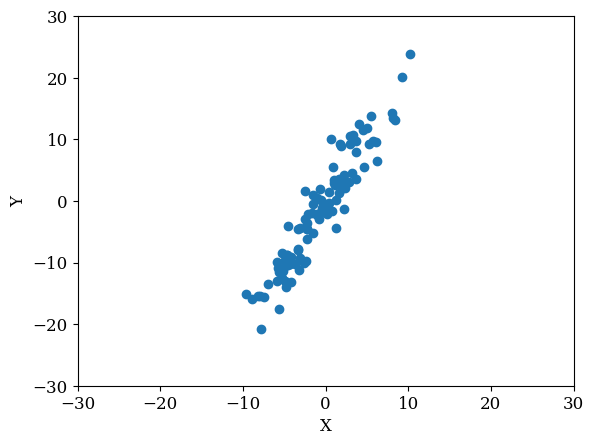

In [167]:
simple_plot(x, y)
plt.savefig("PCA-fig1.png")

## Calculating the covariance matrix of the data

This is handled by `numpy`'s `cov` function

In [168]:
C = np.cov(x, y)

In [169]:
print(C)

[[18.54765404 37.26029664]
 [37.26029664 83.77391901]]


In [170]:
A = pd.DataFrame(C)
A.columns = ['']*A.shape[1]
print(A.to_string(index=False))

                   
18.547654 37.260297
37.260297 83.773919


## Calculating the eigenvalues and eigenvectors

This can be done in a variety of ways, some optimised for specific situations. We have at least the following options:
 - `np.linalg.eig` calculates eigenvalues and right eigenvectors for non-symmetric arrays
 - `np.linalg.eigh` does the same for real symmetric or complex Hermitian arrays
 - `np.linalg.eigvalsh` works like `np.eigh` but only calculates eigenvalues
 - `scipy.linalg.eigh` - very similar to `np.eigh` but has support for the [generalised eigenvalue problem](https://en.wikipedia.org/wiki/Generalized_eigenvector).
 
 Since covariance matrices are symmetric and in our case real, `eigh` is the most suitable option.

In [285]:
sig_x = np.std(x)
sig_y = np.std(y)
mn_x = np.mean(x)
mn_y = np.mean(y)
C = np.cov((x-mn_x), (y-mn_y))

In [212]:
e_vals, e_vecs = np.linalg.eigh(C)

In [213]:
print("Eigenvalues = ", e_vals)

Eigenvalues =  [  1.643657   100.67791605]


In [215]:
print(" First eigenvector", e_vecs[:, 0])
print("Second eigenvector", e_vecs[:, 1])

 First eigenvector [-0.91066548  0.4131445 ]
Second eigenvector [0.4131445  0.91066548]


And show these eigenvectors

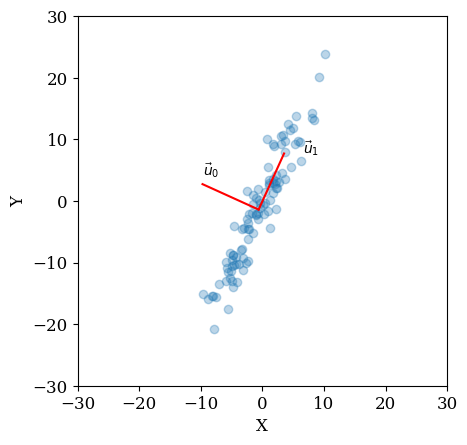

In [229]:
simple_plot(x, y, alpha=0.3)

labels = [r"$\vec{u}_0$", r"$\vec{u}_1$"]
dx = [0, +3]
dy = [1.5, 0]
for i in range(2):   
    start = np.array([mn_x, mn_y])
    end = start + 10*e_vecs[:, i]
    
    xl = [start[0], end[0]]
    yl = [start[1], end[1]]    
    plt.plot(xl, yl, color='red')
    plt.annotate(labels[i], xy=(xl[1], yl[1]), xytext=(xl[1]+dx[i], yl[1]+dy[i]))
#                arrowprops=dict(facecolor='black', shrink=0.05))
    
plt.savefig("PCA-fig2.png")

ax=plt.gca()
ax.set_aspect('equal')

## An alternative derivation using SVD

It is also possible to use singular value decomposition to get the eigenvectors. This is done using `np.linalg.svd` as show below. This particular approach avoids the creation of the covariance matrix as an intermediate step.

In [244]:
N = len(x)
xData = np.reshape(x, (N, 1))
yData = np.reshape(y, (N, 1))
data = np.hstack((xData, yData))

mu = data.mean(axis=0)
data = data - mu
eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)

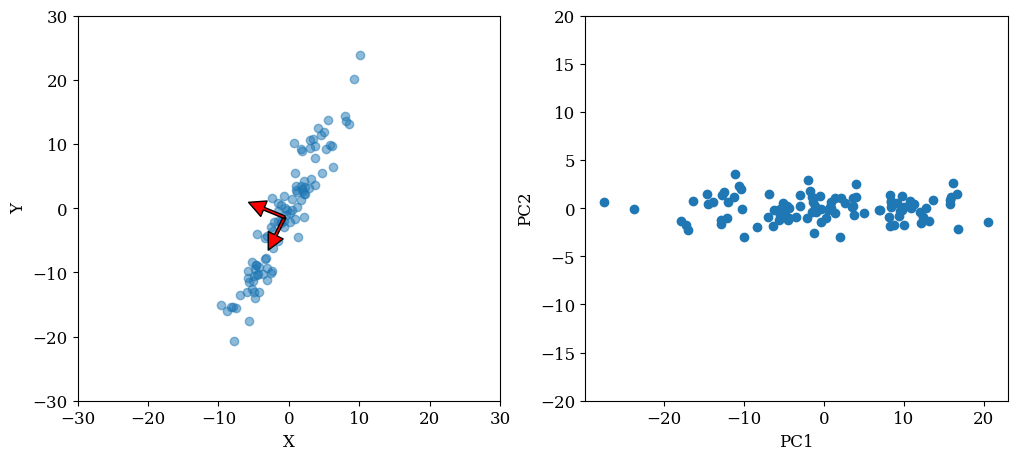

In [251]:
projected_data = np.dot(data, eigenvectors)
sigma = projected_data.std(axis=0).mean()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ax[0].scatter(xData, yData, alpha=0.5)
ax[0].set_xlim(-30, 30)
ax[0].set_ylim(-30, 30)
for axis in eigenvectors:
    start, end = mu, mu + sigma * axis
    ax[0].annotate(
        '', xy=end, xycoords='data',
        xytext=start, textcoords='data',
        arrowprops=dict(facecolor='red', width=2.0))
#ax[0].set_aspect('equal')
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

ax[1].scatter(projected_data[:, 0], projected_data[:, 1])
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")
ax[1].set_ylim(-20, 20)

plt.savefig("PCA-fig3.png")

One can also clearly note the fact that the *direction* of the eigenvectors is defined only up to a sign. You can always reverse the eigenvectors without any implications for the further analysis.

### Different languages - different rules
It is also worth noting that different routines/languages return the eigenvalues/eigenvectors in different orders. In the `numpy` and `scipy` implementations we see here, they are sorted so that the smallest eigenvalue is first. This is also the case with Julia's `eigvals`/`eigvecs` functions, but R's `eigen` function returns the largest first.   

# Projection

While the rotation of coordinate system seen above can be quite useful, PCA is usually done to reduce dimensionality. Since we have a 2D system, this is not terribly useful but the process is the same. To do that, we create a projection matrix, $M$, consisting of the eigenvectors we want to keep and project using this.

In [276]:
M = e_vecs[:, 1]
X = data # See above how this was created
u = np.matmul(X, M)

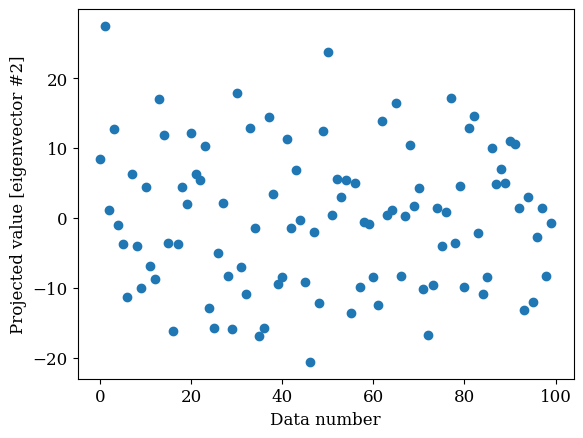

In [277]:
plt.scatter(range(len(u)), u)
plt.ylabel("Projected value [eigenvector #2]")
plt.xlabel("Data number")
plt.savefig("PCA-fig4.png")

But it is probably more useful to see this in the original space. To do that we need to multiply by the eigenvector.

In [281]:
x_recon = u*e_vecs[0, 1]
y_recon = u*e_vecs[1, 1]

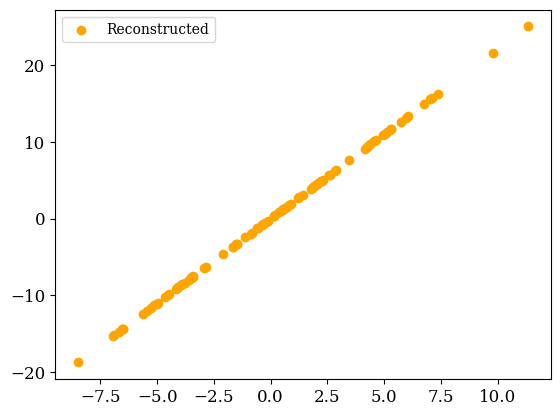

In [292]:
plt.scatter(x_recon, y_recon, label="Reconstructed", color='orange')
plt.legend()
plt.savefig("PCA-fig5.png")

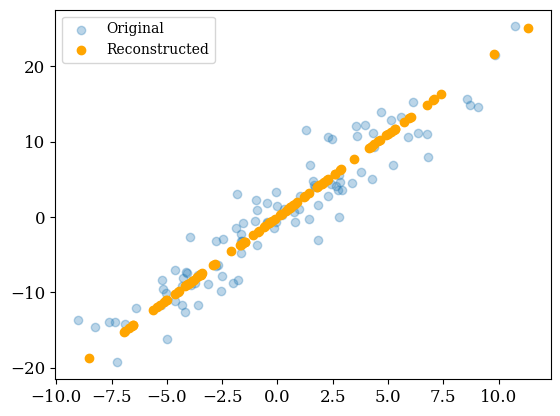

In [293]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.3, label="Original")
plt.scatter(x_recon, y_recon, label="Reconstructed", color='orange')
plt.legend()
plt.savefig("PCA-fig6.png")

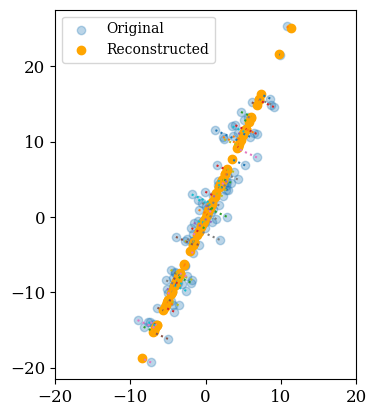

In [294]:
# Finally show orthogonal projection
plt.scatter(data[:, 0], data[:, 1], alpha=0.3, label="Original")
plt.scatter(x_recon, y_recon, label="Reconstructed", color='orange')

for i in range(len(x)):
    plt.plot([data[i, 0], x_recon[i]], [data[i, 1], y_recon[i]], ls='dotted')

plt.legend()
plt.xlim(-20, 20)
ax=plt.gca()
ax.set_aspect('equal')

plt.savefig("PCA-fig7.png")

# How we actually do PCA

In general we do not do all these steps manually - we usually use ready-made packages for this. In `sklearn` the natural choice is `sklearn.decomposition.PCA`:

In [295]:
from sklearn.decomposition import PCA

In [304]:
# Let us do PCA with one component
pca = PCA(n_components=1)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.98393636]


The `fit` function runs PCA, while the `fit_transform` function runs PCA and projects the data to the new space. After projected data have been calculated, we can then use the `inverse_transform` function to go back to the original space. 

In [305]:
X_projected = pca.fit_transform(X)
X_recon = pca.inverse_transform(X_projected)

And we can show that this gives the same projected data as above

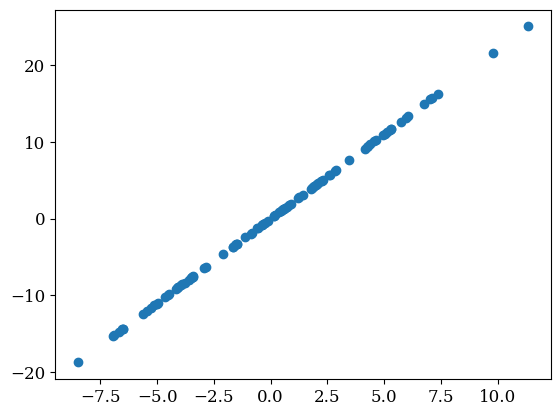

In [303]:

plt.scatter(X_recon[:, 0], X_recon[:, 1])

The advantage of the `sklearn` approach is of course that is easier, extends naturally to higher dimensions and can be chained into analysis pipelines.